In [1]:
import pandas as pd
import numpy as np

In [83]:
pd.options.mode.chained_assignment = None  # default='warn'

## Loading GDSC raw data

In [2]:
GDSC1 = "https://cog.sanger.ac.uk/cancerrxgene/GDSC_release8.4/GDSC1_public_raw_data_24Jul22.csv.zip"
GDSC2 = "https://cog.sanger.ac.uk/cancerrxgene/GDSC_release8.4/GDSC2_public_raw_data_24Jul22.csv.zip"


In [3]:
#Conbining the raw datasets 
GDSC1_df = pd.read_csv(GDSC1)
GDSC2_df = pd.read_csv(GDSC2)
GDSC_combined_df = pd.concat([GDSC1_df,GDSC2_df])
print(GDSC_combined_df.shape)
GDSC_combined_df.head()

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\4001120376.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  GDSC1_df = pd.read_csv(GDSC1)


(21045632, 19)


,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,SEEDING_DENSITY,DRUGSET_ID,ASSAY,DURATION,POSITION,TAG,DRUG_ID,CONC,INTENSITY
0,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,1,B,NaN,NaN,26022
1,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,2,B,NaN,NaN,20491
2,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,3,UN-USED,NaN,NaN,181946
3,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,4,UN-USED,NaN,NaN,213387
4,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,5,UN-USED,NaN,NaN,166452


In [4]:
# single_row_per_plate = (GDSC_combined_df[GDSC_combined_df.POSITION==1])
# single_row_per_plate.shape

In [96]:
# Number of unique plates
Plate_ids = GDSC_combined_df.BARCODE.unique()
len(Plate_ids)

40252

In [6]:
#single_row_plate_ids = single_row_per_plate.BARCODE.unique()

In [7]:
# missing_plates = list(set(list(Plate_ids)).difference(list(single_row_plate_ids)))
# missing_plates

In [8]:
# for plate in missing_plates:
#     print(plate, GDSC_combined_df[GDSC_combined_df.BARCODE==plate].shape)

In [9]:
# plate_102720 = GDSC_combined_df[GDSC_combined_df.BARCODE==102720].head()
# plate_102720[plate_102720.POSITION==1]

In [10]:
# Grouping by plate layout (Drugset_id) and getting the count of the number of plates usingin this layout and their max wells
group_test = GDSC_combined_df.groupby(["DRUGSET_ID"]).agg({"BARCODE":pd.Series.nunique,'POSITION':'max'})
group_test

,BARCODE,POSITION
DRUGSET_ID,,
158,284,1536
159,890,1536
217,605,1536
231,476,1536
264,98,1536
...,...,...
714_i_17,36,384
714_j_16,51,384
714_j_17,6,384


In [11]:
#dropping unused rows
drop_unused = (GDSC_combined_df[GDSC_combined_df.TAG!="UN-USED"])
drop_unused.shape

(15255520, 19)

### Identifying which plates use which controls

In [12]:
layouts_w_NC0 = drop_unused[drop_unused.TAG=='NC-0'].DRUGSET_ID.unique()
len(layouts_w_NC0)

### Therefore all plates have NC-0

230

In [13]:
layouts_w_NC1 = drop_unused[drop_unused.TAG=='NC-1'].DRUGSET_ID.unique()
len(layouts_w_NC1)

86

In [14]:
layouts_w_PC1 = drop_unused[drop_unused.TAG=='PC-1'].DRUGSET_ID.unique()
len(layouts_w_PC1)

3

In [15]:
layouts_w_titred_PC1 = drop_unused[drop_unused.TAG.str.startswith('PC1-D')].DRUGSET_ID.unique()
len(layouts_w_titred_PC1)

83

In [16]:
layouts_w_titred_PC2 = drop_unused[drop_unused.TAG.str.startswith('PC2-D')].DRUGSET_ID.unique()
len(layouts_w_titred_PC2)

83

In [17]:
nine_fold = drop_unused[drop_unused.TAG.str.endswith('D9-S')].DRUGSET_ID.unique()
len(nine_fold)

83

In [18]:
layouts_w_DMSO = drop_unused[drop_unused.TAG=='DMSO'].DRUGSET_ID.unique()
len(layouts_w_DMSO)

79

In [19]:
group_test.reset_index(inplace=True)
group_test

,DRUGSET_ID,BARCODE,POSITION
0,158,284,1536
1,159,890,1536
2,217,605,1536
3,231,476,1536
4,264,98,1536
...,...,...,...
225,714_i_17,36,384
226,714_j_16,51,384
227,714_j_17,6,384
228,714_k_16,10,384


### Summary table of layout, # of plates for the layout, well count and what control wells used. Also included indictor for plate which did assays in sets of 9 wells rather than 5 

In [20]:
group_test['NC-0']=np.where(group_test.DRUGSET_ID.isin(layouts_w_NC0),True,False)
group_test['NC-1']=np.where(group_test.DRUGSET_ID.isin(layouts_w_NC1),True,False)
group_test['PC-1']=np.where(group_test.DRUGSET_ID.isin(layouts_w_PC1),True,False)
group_test['Titred PC-1']=np.where(group_test.DRUGSET_ID.isin(layouts_w_titred_PC1),True,False)
group_test['Titred PC-2']=np.where(group_test.DRUGSET_ID.isin(layouts_w_titred_PC2),True,False)
group_test['nine_fold']=np.where(group_test.DRUGSET_ID.isin(nine_fold),True,False)
group_test['DMSO']=np.where(group_test.DRUGSET_ID.isin(layouts_w_DMSO),True,False)
group_test

,DRUGSET_ID,BARCODE,POSITION,NC-0,NC-1,PC-1,Titred PC-1,Titred PC-2,nine_fold,DMSO
0,158,284,1536,True,True,True,False,False,False,False
1,159,890,1536,True,True,True,False,False,False,False
2,217,605,1536,True,True,True,False,False,False,False
3,231,476,1536,True,True,False,True,True,False,False
4,264,98,1536,True,True,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...
225,714_i_17,36,384,True,False,False,False,False,False,False
226,714_j_16,51,384,True,False,False,False,False,False,False
227,714_j_17,6,384,True,False,False,False,False,False,False
228,714_k_16,10,384,True,False,False,False,False,False,False


In [21]:
# Number of plates by there different sizes
group_test.POSITION.value_counts()

384     130
1536     86
96       14
Name: POSITION, dtype: int64

In [22]:
group_test['NC-1'].value_counts()

False    144
True      86
Name: NC-1, dtype: int64

In [23]:
group_test.nine_fold.value_counts()

False    147
True      83
Name: nine_fold, dtype: int64

In [24]:
group_test[group_test.nine_fold==True]

,DRUGSET_ID,BARCODE,POSITION,NC-0,NC-1,PC-1,Titred PC-1,Titred PC-2,nine_fold,DMSO
86,14_a_7,241,384,True,False,False,False,False,True,False
87,15_a_7,282,384,True,False,False,False,False,True,False
88,16_a_7,245,384,True,False,False,False,False,True,False
89,16_b_7,23,384,True,False,False,False,False,True,False
90,17_a_7,963,384,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
164,508_f_16,22,384,True,False,False,False,False,True,False
165,508_g_16,28,384,True,False,False,False,False,True,False
166,508_g_5,27,384,True,False,False,False,False,True,False
167,508_h_16,19,384,True,False,False,False,False,True,False


In [25]:
# of unique plates
drop_unused.BARCODE.nunique()

40251

## Identifying triplicates

In [26]:
#getting list of unique plate layouts
layout_list = list(drop_unused.DRUGSET_ID.unique())

In [97]:
#Grouping the raw dataset by number of plates with the same layout and cell line

Layout_cell_line_grouped = GDSC_combined_df.groupby(["DRUGSET_ID","CELL_LINE_NAME"]).agg({"BARCODE":pd.Series.nunique})
Layout_cell_line_grouped

BARCODE
DRUGSET_ID CELL_LINE_NAME         
158        23132-87              1
           42-MG-BA              1
           5637                  1
           639-V                 1
           647-V                 1
...                            ...
714_k_17   MFM-223               3
           MHH-ES-1              3
           PC-14                 3
           SK-MEL-2              3
           SW620                 3

[33931 rows x 1 columns]

In [28]:
#Extracting layouts+cell lines where there are triplicate plates

Triplicate_layouts = Layout_cell_line_grouped[Layout_cell_line_grouped.BARCODE ==3]
Triplicate_layouts

BARCODE
DRUGSET_ID CELL_LINE_NAME         
158        HCC-78                3
           NUGC-3                3
159        DiFi                  3
           HC-1                  3
231        A3-KAW                3
...                            ...
714_k_17   MFM-223               3
           MHH-ES-1              3
           PC-14                 3
           SK-MEL-2              3
           SW620                 3

[515 rows x 1 columns]

### This function will return the Barcodes to identify plates for a given layout and cell line

In [29]:

def barcode_fetcher(plate_layout,cell_line):
    plate_df = drop_unused[(drop_unused.DRUGSET_ID == plate_layout) & (drop_unused.CELL_LINE_NAME==cell_line)]
    return list(plate_df.BARCODE.unique())

In [30]:
barcode_fetcher(158,'HCC-78')

[6617, 6864, 7265]

In [31]:
group_test[group_test['DRUGSET_ID'] ==158]

,DRUGSET_ID,BARCODE,POSITION,NC-0,NC-1,PC-1,Titred PC-1,Titred PC-2,nine_fold,DMSO
0,158,284,1536,True,True,True,False,False,False,False


In [32]:
barcode_fetcher('714_k_17','MFM-223')

['127950', '127955', '127945']

In [33]:
group_test[group_test['DRUGSET_ID'] =='714_k_17']

,DRUGSET_ID,BARCODE,POSITION,NC-0,NC-1,PC-1,Titred PC-1,Titred PC-2,nine_fold,DMSO
229,714_k_17,24,384,True,False,False,False,False,False,False


### For simplicity, will work only with plates that only use the NC-0 and B controls

In [34]:
Only_NC0 = group_test[(group_test['NC-1']==False)&
                      (group_test['PC-1']==False)&
                      (group_test['Titred PC-1']==False)&
                      (group_test['Titred PC-2']==False)&
                      (group_test['DMSO']==False)]
Only_NC0

,DRUGSET_ID,BARCODE,POSITION,NC-0,NC-1,PC-1,Titred PC-1,Titred PC-2,nine_fold,DMSO
86,14_a_7,241,384,True,False,False,False,False,True,False
87,15_a_7,282,384,True,False,False,False,False,True,False
88,16_a_7,245,384,True,False,False,False,False,True,False
89,16_b_7,23,384,True,False,False,False,False,True,False
90,17_a_7,963,384,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
225,714_i_17,36,384,True,False,False,False,False,False,False
226,714_j_16,51,384,True,False,False,False,False,False,False
227,714_j_17,6,384,True,False,False,False,False,False,False
228,714_k_16,10,384,True,False,False,False,False,False,False


In [35]:
Only_NC0_layout_list = Only_NC0.DRUGSET_ID.to_list()

In [36]:
Triplicate_layouts.loc['714_k_17']

,BARCODE
CELL_LINE_NAME,
A375,3
A549,3
C32,3
MFM-223,3
MHH-ES-1,3
PC-14,3
SK-MEL-2,3
SW620,3


In [37]:
Trip_layout_list = list(set(Triplicate_layouts.index.get_level_values(0).to_list()))
Trip_layout_list[:10]

['26_b_7', '505_a_16', 517, 519, 525, 527, 529, '406_a_9', 545, 547]

In [38]:
NC0_in_trip = list(set(Only_NC0_layout_list).intersection(Trip_layout_list))
len(NC0_in_trip)

57

### Below are the layouts+cell lines with triplicate plates using only NC-0 and B ass controls

In [39]:
Only_NCO_Trips = Triplicate_layouts.loc[NC0_in_trip]
Only_NCO_Trips

BARCODE
DRUGSET_ID CELL_LINE_NAME         
26_b_7     NCI-H2141             3
505_a_16   ML-2                  3
           SBC-1                 3
714_k_16   RPMI-8226             3
411_a_9    RPMI-6666             3
...                            ...
713_a_17   MKN28                 3
           NB69                  3
           PC-14                 3
           SK-MEL-2              3
           SW620                 3

[317 rows x 1 columns]

In [40]:
NC0_in_trip[-20:]

['714_i_16',
 '711_b_17',
 '714_h_17',
 '711_d_17',
 '18_a_7',
 '403_a_9',
 '28_b_7',
 '506_f_6',
 '25_a_7',
 '712_f_17',
 '15_a_7',
 '22_a_7',
 '505_a_6',
 '17_a_7',
 '26_a_7',
 '21_b_7',
 '408_a_9',
 '402_a_9',
 '26_c_7',
 '713_a_17']

In [41]:
len(NC0_in_trip)

57

In [98]:
#Triplicate_layouts.loc['714_b_17']

In [99]:
#Triplicate_layouts.loc['507_c_5']

In [44]:
Only_NCO_Trips.loc['713_m_17']

,BARCODE
CELL_LINE_NAME,
A549,3
C32,3
MFM-223,3
MHH-ES-1,3
PC-14,3
SK-MEL-2,3
SW620,3
SiHa,3


In [45]:
barcode_fetcher('714_b_17','C32')

[115848, 115761, '115853']

In [46]:
#exploring for the '714_b_17' layout, C32 cell line and 1375 drug

P_714_b_17_CL_C32_D_1375  = drop_unused[(drop_unused.BARCODE.isin([115848, 115761, '115853']))&(drop_unused.DRUG_ID==1375)]
P_714_b_17_CL_C32_D_1375

,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,SEEDING_DENSITY,DRUGSET_ID,ASSAY,DURATION,POSITION,TAG,DRUG_ID,CONC,INTENSITY
2637606,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,61,L7-D1-S,1375.0,30.000000,270189
2637607,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,62,L7-D2-S,1375.0,7.500000,264862
2637608,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,63,L7-D3-S,1375.0,1.875000,267270
2637609,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,64,L7-D4-S,1375.0,0.468750,258850
2637610,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,65,L7-D5-S,1375.0,0.117188,269534
2642677,Sanger_GDSC1,115761,58229,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1800.0,714_b_17,a,3.0,61,L7-D1-S,1375.0,30.000000,246600
2642678,Sanger_GDSC1,115761,58229,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1800.0,714_b_17,a,3.0,62,L7-D2-S,1375.0,7.500000,279440
2642679,Sanger_GDSC1,115761,58229,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1800.0,714_b_17,a,3.0,63,L7-D3-S,1375.0,1.875000,277995
2642680,Sanger_GDSC1,115761,58229,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1800.0,714_b_17,a,3.0,64,L7-D4-S,1375.0,0.468750,267388
2642681,Sanger_GDSC1,115761,58229,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1800.0,714_b_17,a,3.0,65,L7-D5-S,1375.0,0.117188,259252


In [47]:
P_714_b_17_CL_C32_D_1375.shape

(15, 19)

In [100]:
#selecting columns of interest

tidy_test = P_714_b_17_CL_C32_D_1375[['CELL_LINE_NAME','DRUG_ID','BARCODE','CONC','INTENSITY']]
tidy_test

,CELL_LINE_NAME,DRUG_ID,BARCODE,CONC,INTENSITY
2637606,C32,1375.0,115848,30.000000,270189
2637607,C32,1375.0,115848,7.500000,264862
2637608,C32,1375.0,115848,1.875000,267270
2637609,C32,1375.0,115848,0.468750,258850
2637610,C32,1375.0,115848,0.117188,269534
2642677,C32,1375.0,115761,30.000000,246600
2642678,C32,1375.0,115761,7.500000,279440
2642679,C32,1375.0,115761,1.875000,277995
2642680,C32,1375.0,115761,0.468750,267388
2642681,C32,1375.0,115761,0.117188,259252


In [49]:
30/7.5

4.0

In [50]:
7.5/4

1.875

## Normalisation

"Now the data can be normalized. By normalization we mean converting the raw fluourescence intensities for the treated wells (the read-out from the assay) to a cell viability value between 0 and 1. We assume that the dynamic range for the cell viability is bounded by the mean of the positive controls ($\mu_{pos}$) and the mean of the negative controls ($\mu_{neg}$), equivalent to a viablilty of 0 and 1 respectively. The normalization is always done on a per plate basis."

"$$viability = \frac{intensity - \mu_{pos} }{ \mu_{neg} - \mu_{pos}}$$"

In [51]:
drop_unused.loc[(drop_unused.BARCODE==115848)&(drop_unused.TAG=='B')].head()

,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,SEEDING_DENSITY,DRUGSET_ID,ASSAY,DURATION,POSITION,TAG,DRUG_ID,CONC,INTENSITY
2637566,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,1,B,NaN,NaN,14510
2637590,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,25,B,NaN,NaN,16091
2637604,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,49,B,NaN,NaN,15556
2637618,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,73,B,NaN,NaN,14987
2637627,Sanger_GDSC1,115848,58183,2013-02-28T00:00:00Z,NaN,2003,2242,906830,C32,SIDM00890,1700.0,714_b_17,a,3.0,97,B,NaN,NaN,15356


In [52]:
drop_unused.loc[(drop_unused.BARCODE==115848)&(drop_unused.TAG=='B'),'INTENSITY'].mean()

15146.0

In [53]:
#exploring how to get mean pos and neg controls from 3 selected plates

plates_test_norm = [115848, 115761, '115853']
pos_controls = {}
neg_controls = {}
for plate in plates_test_norm:
    mean_pos = drop_unused.loc[(drop_unused.BARCODE==plate)&(drop_unused.TAG=='B'),'INTENSITY'].mean()
    # note - using NC-0 as negative control was not restricting between 0 and 1. 
    # Appears there can be cases where the untreeated wells do not actually have the highest intensity e.g low drug treated wells 
    # could be higher. Decided to use max intensitiy well per plate as the neg contorl to overcome this
    mean_neg = drop_unused.loc[(drop_unused.BARCODE==plate),'INTENSITY'].max()
    #mean_neg = drop_unused.loc[(drop_unused.BARCODE==plate)&(drop_unused.TAG=='NC-0'),'INTENSITY'].mean()
    pos_controls[plate]=mean_pos
    neg_controls[plate]=mean_neg

neg_controls

{115848: 343178, 115761: 318420, '115853': 318442}

In [54]:
tidy_test['mean_pos'] = tidy_test['BARCODE'].map(pos_controls)
tidy_test['mean_neg'] = tidy_test['BARCODE'].map(neg_controls)
tidy_test['Norm'] = ((tidy_test.INTENSITY-tidy_test.mean_pos)/(tidy_test.mean_neg-tidy_test.mean_pos))
tidy_test.head()

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\2997239032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_test['mean_pos'] = tidy_test['BARCODE'].map(pos_controls)
C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\2997239032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_test['mean_neg'] = tidy_test['BARCODE'].map(neg_controls)
C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\2997239032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

,CELL_LINE_NAME,DRUG_ID,BARCODE,CONC,INTENSITY,mean_pos,mean_neg,Norm
2637606,C32,1375.0,115848,30.000000,270189,15146.0,343178,0.777494
2637607,C32,1375.0,115848,7.500000,264862,15146.0,343178,0.761255
2637608,C32,1375.0,115848,1.875000,267270,15146.0,343178,0.768596
2637609,C32,1375.0,115848,0.468750,258850,15146.0,343178,0.742928
2637610,C32,1375.0,115848,0.117188,269534,15146.0,343178,0.775498


In [55]:
tidy_test.tail()

,CELL_LINE_NAME,DRUG_ID,BARCODE,CONC,INTENSITY,mean_pos,mean_neg,Norm
2660145,C32,1375.0,115853,30.000000,260617,13791.375,318442,0.810192
2660146,C32,1375.0,115853,7.500000,259550,13791.375,318442,0.806690
2660147,C32,1375.0,115853,1.875000,263674,13791.375,318442,0.820227
2660148,C32,1375.0,115853,0.468750,259480,13791.375,318442,0.806460
2660149,C32,1375.0,115853,0.117188,250903,13791.375,318442,0.778307


In [56]:
#tidy_test['Norm'] = tidy_test.apply(lambda x: (x.INTENSITY - mean_controls[x.BARCODE][0])/mean_controls[x.BARCODE][1]-mean_controls[x.BARCODE][0],axis=1)

In [58]:
# spot-checking maths
(270189-15146.0)/(260966.41666666666-15146.0)

1.0375175644822017

#### Normalising drug conc
This scale is set with the maximum concentration at 9 because the original GDSC data used a 9 point 2 fold dilution for each drug treatment, hence dilution points from 9 down to 1. Newer data has adopted different dilution ranges but the maximum of 9 has been kept and so the same function can be used to normalize the concentration scale.

"maxc is the maximum concentration for that drug treatment in micromolar.

x is the concentration on a scale up to 9, where:"

$$ x = ~ \frac{log\frac{CONC}{maxc}}{log(2)} + 9$$

In [59]:
tidy_test.loc[:,'CONC'].max()

30.0

In [60]:
tidy_test.CONC.nunique()

5

In [61]:
tidy_test['norm_dose']=((np.log(tidy_test['CONC']/tidy_test.loc[:,'CONC'].max()))/np.log(2))+9
tidy_test.head()

#drop_unused.loc[(drop_unused.BARCODE==plate),'INTENSITY'].max()

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\3313928020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_test['norm_dose']=((np.log(tidy_test['CONC']/tidy_test.loc[:,'CONC'].max()))/np.log(2))+9


,CELL_LINE_NAME,DRUG_ID,BARCODE,CONC,INTENSITY,mean_pos,mean_neg,Norm,norm_dose
2637606,C32,1375.0,115848,30.000000,270189,15146.0,343178,0.777494,9.0
2637607,C32,1375.0,115848,7.500000,264862,15146.0,343178,0.761255,7.0
2637608,C32,1375.0,115848,1.875000,267270,15146.0,343178,0.768596,5.0
2637609,C32,1375.0,115848,0.468750,258850,15146.0,343178,0.742928,3.0
2637610,C32,1375.0,115848,0.117188,269534,15146.0,343178,0.775498,1.0


##  Testing Curve fitting

### Trying method from here https://jbloomlab.github.io/neutcurve/curvefits_example.html 
### This method didn't really work for me

In [62]:
#pip install neutcurve

In [63]:
import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

In [64]:
rename_dict = {'CELL_LINE_NAME':'serum',
               'DRUG_ID':'virus',
               'BARCODE':'replicate',
               'CONC':'concentration',
               'Norm':'fraction infectivity'}

In [65]:
tidy_renamed = tidy_test[['CELL_LINE_NAME','DRUG_ID','BARCODE','CONC','Norm']]
tidy_renamed.rename(columns=rename_dict, inplace=True)
tidy_renamed.head()

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\2928074161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_renamed.rename(columns=rename_dict, inplace=True)


,serum,virus,replicate,concentration,fraction infectivity
2637606,C32,1375.0,115848,30.000000,0.777494
2637607,C32,1375.0,115848,7.500000,0.761255
2637608,C32,1375.0,115848,1.875000,0.768596
2637609,C32,1375.0,115848,0.468750,0.742928
2637610,C32,1375.0,115848,0.117188,0.775498


In [66]:
fits = neutcurve.CurveFits(tidy_renamed)

### Trying other method from here https://gist.github.com/yannabraham/5f210fed773785d8b638

In [67]:
# curve = fits.getCurve(serum='C32', virus=1375, replicate='115848')
# fig, ax = curve.plot()

In [68]:
#pip install seaborn

In [69]:
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [70]:
def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))

In [71]:
tidy_2 = tidy_test.loc[:,['DRUG_ID','CONC',"Norm"]]
tidy_2['logDose'] = pDose(tidy_2.CONC)
tidy_2['norm_dose']=((np.log10(tidy_2['CONC']/tidy_2.loc[:,'CONC'].max()))/np.log10(2))+9
tidy_2

,DRUG_ID,CONC,Norm,logDose,norm_dose
2637606,1375.0,30.000000,0.777494,4.522879,9.0
2637607,1375.0,7.500000,0.761255,5.124939,7.0
2637608,1375.0,1.875000,0.768596,5.726999,5.0
2637609,1375.0,0.468750,0.742928,6.329059,3.0
2637610,1375.0,0.117188,0.775498,6.931119,1.0
2642677,1375.0,30.000000,0.763850,4.522879,9.0
2642678,1375.0,7.500000,0.871830,5.124939,7.0
2642679,1375.0,1.875000,0.867079,5.726999,5.0
2642680,1375.0,0.468750,0.832202,6.329059,3.0
2642681,1375.0,0.117188,0.805451,6.931119,1.0


In [72]:
def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

In [73]:
compoundData = tidy_2.groupby(['DRUG_ID'])
fitData = []
for name,group in compoundData:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.norm_dose, group.Norm)
    resids = group.Norm-group.norm_dose.apply(lambda x: ll4(x,*fitCoefs))
    curFit = dict(zip(['b','c','d','e'],fitCoefs))
    curFit['compound']=name
    curFit['residuals']=sum(resids**2)
    fitData.append(curFit)
fitCompound = [ item['compound'] for item in fitData]


C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\3159691884.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


In [74]:
fitTable = pd.DataFrame(fitData).set_index('compound')
fitTable

,b,c,d,e,residuals
compound,,,,,
1375.0,32.070657,0.805246,0.786418,3.039969,0.01904


In [75]:
# fitTable = pd.DataFrame(fitData).set_index('compound')
# paramTable = pd.DataFrame(params).set_index('compound')[['b','c','d','e']]
# paramTable.columns = ['ref_'+i for i in paramTable.columns]
# fitTable.join(paramTable)

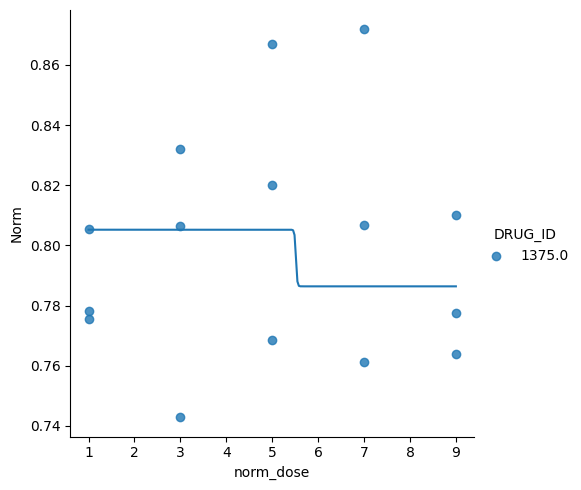

In [76]:
refDose = np.linspace(min(tidy_2.norm_dose),max(tidy_2.norm_dose),256)
#refDose = np.linspace(min(tidy_2.logDose)*0.9,max(tidy_2.logDose)*1.1,256)
refDose = (10**-refDose)*1e6
sns.lmplot(data = tidy_2,  x= 'norm_dose',y = 'Norm', hue='DRUG_ID',fit_reg=False)
for fit in fitData:
    plt.plot([pDose(i) for i in refDose],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])

In [77]:
# number_plates_per_layout = []
# for layout in layout_list:
#     df = drop_unused[drop_unused.DRUGSET_ID==layout]
#     count = df.BARCODE.nunique()
#     number_plates_per_layout.append(count)

In [78]:
# print(len(number_plates_per_layout))
# print(sum(number_plates_per_layout))

In [79]:
# plate_summary_df = pd.DataFrame(index=layout_list).reset_index()
# plate_summary_df.head()

In [80]:
# plate_summary_df['N_plates'] = number_plates_per_layout
# plate_summary_df.head()

In [81]:
# plate_summary_df[plate_summary_df['index']==158]

## Functions for generating data for curves and drawing curves

In [82]:
def data_for_curve(plate_layout, cell_line, drug):
    #fetch list of plate barcode ids for the chosen layout and cell line
    plate_list = barcode_fetcher(plate_layout, cell_line)    

    pos_controls = {}
    neg_controls = {}
    #choose neg and pos controls to normalise response varible
    for plate in plate_list:
        #mean_pos uses blank wells where no cells are present
        mean_pos = drop_unused.loc[(drop_unused.BARCODE==plate)&(drop_unused.TAG=='B'),'INTENSITY'].mean()
        #mean_neg = drop_unused.loc[(drop_unused.BARCODE==plate)&(drop_unused.TAG=='NC-0'),'INTENSITY'].mean() 
        #NOTE - take the neg control as the max intensity for the plate since there seems to be 
        # cases where low drug concentration wells are higher then the average negative wells.
        mean_neg = drop_unused.loc[(drop_unused.BARCODE==plate),'INTENSITY'].max()
        pos_controls[plate]=mean_pos
        neg_controls[plate]=mean_neg
    
    #make mini df of chosen plates and drug
    plates_df  = drop_unused[(drop_unused.BARCODE.isin(plate_list))&(drop_unused.DRUG_ID==drug)]
    tidy_df= plates_df[['CELL_LINE_NAME','DRUG_ID','BARCODE','CONC','INTENSITY']] 

    tidy_df['mean_pos'] = tidy_df['BARCODE'].map(pos_controls)
    tidy_df['mean_neg'] = tidy_df['BARCODE'].map(neg_controls)
    tidy_df['Norm'] = ((tidy_df.INTENSITY-tidy_df.mean_pos)/(tidy_df.mean_neg-tidy_df.mean_pos))

    tidy_2 = tidy_df.loc[:,['DRUG_ID','CONC',"Norm"]]
    
    #tidy_2['logDose'] = pDose(tidy_2.CONC)
    #normalise drug conc from 1 to 9 (note- even 5 fold dilutions will use this scale)
    tidy_2['norm_dose']=((np.log10(tidy_2['CONC']/tidy_2.loc[:,'CONC'].max()))/np.log10(2))+9
    tidy_2['logDose'] = pDose(tidy_2.norm_dose)
    tidy_2['logCONC']=pDose(tidy_2.CONC)
    return tidy_2

In [84]:
data_for_curve('714_b_17','C32',1375)

,DRUG_ID,CONC,Norm,norm_dose,logDose,logCONC
2637606,1375.0,30.000000,0.777494,9.0,5.045757,4.522879
2637607,1375.0,7.500000,0.761255,7.0,5.154902,5.124939
2637608,1375.0,1.875000,0.768596,5.0,5.301030,5.726999
2637609,1375.0,0.468750,0.742928,3.0,5.522879,6.329059
2637610,1375.0,0.117188,0.775498,1.0,6.000000,6.931119
2642677,1375.0,30.000000,0.763850,9.0,5.045757,4.522879
2642678,1375.0,7.500000,0.871830,7.0,5.154902,5.124939
2642679,1375.0,1.875000,0.867079,5.0,5.301030,5.726999
2642680,1375.0,0.468750,0.832202,3.0,5.522879,6.329059
2642681,1375.0,0.117188,0.805451,1.0,6.000000,6.931119


In [85]:
def curve_fit(data_df):
    compoundData = data_df.groupby(['DRUG_ID'])
    fitData = []
    for name,group in compoundData:
        fitCoefs, covMatrix = opt.curve_fit(ll4, group.norm_dose, group.Norm)
        resids = group.Norm-group.norm_dose.apply(lambda x: ll4(x,*fitCoefs))
        curFit = dict(zip(['b','c','d','e'],fitCoefs))
        curFit['compound']=name
        curFit['residuals']=sum(resids**2)
        fitData.append(curFit)
    fitCompound = [ item['compound'] for item in fitData]

    fitTable = pd.DataFrame(fitData).set_index('compound')

    refDose = np.linspace(min(data_df.norm_dose),max(data_df.norm_dose),256)
    refDose = (10**-refDose)*1e6
    sns.lmplot(data = data_df,  x= 'norm_dose',y = 'Norm', hue='DRUG_ID',fit_reg=False)
    for fit in fitData:
        curve = plt.plot([pDose(i) for i in refDose],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])
        #curve = plt.plot([pDose(i) for i in refDose],[ll4(i,*[fit[i] for i in ['b','c','d','e']]) for i in refDose])

    return curve

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\4151788788.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


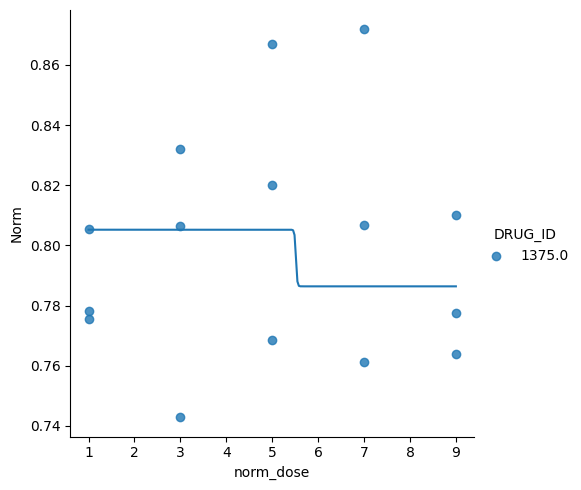

In [86]:
curve_fit(data_for_curve('714_b_17','C32',1375))

In [87]:
data_for_curve('714_b_17','A375',1375)

,DRUG_ID,CONC,Norm,norm_dose,logDose,logCONC
2634167,1375.0,30.000000,0.470438,9.0,5.045757,4.522879
2634168,1375.0,7.500000,0.527917,7.0,5.154902,5.124939
2634169,1375.0,1.875000,0.531163,5.0,5.301030,5.726999
2634170,1375.0,0.468750,0.580042,3.0,5.522879,6.329059
2634171,1375.0,0.117188,0.635891,1.0,6.000000,6.931119
2637407,1375.0,30.000000,0.629171,9.0,5.045757,4.522879
2637408,1375.0,7.500000,0.723826,7.0,5.154902,5.124939
2637409,1375.0,1.875000,0.787145,5.0,5.301030,5.726999
2637410,1375.0,0.468750,0.755573,3.0,5.522879,6.329059
2637411,1375.0,0.117188,0.855146,1.0,6.000000,6.931119


In [88]:
data_for_curve('714_b_17','HT-29',1375)

,DRUG_ID,CONC,Norm,norm_dose,logDose,logCONC
2634530,1375.0,30.000000,0.942033,9.0,5.045757,4.522879
2634531,1375.0,7.500000,0.966403,7.0,5.154902,5.124939
2634532,1375.0,1.875000,0.934706,5.0,5.301030,5.726999
2634533,1375.0,0.468750,0.895530,3.0,5.522879,6.329059
2634534,1375.0,0.117188,0.887339,1.0,6.000000,6.931119
2644106,1375.0,30.000000,0.860316,9.0,5.045757,4.522879
2644107,1375.0,7.500000,0.923304,7.0,5.154902,5.124939
2644108,1375.0,1.875000,0.852563,5.0,5.301030,5.726999
2644109,1375.0,0.468750,0.830448,3.0,5.522879,6.329059
2644110,1375.0,0.117188,0.863029,1.0,6.000000,6.931119


C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\4151788788.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


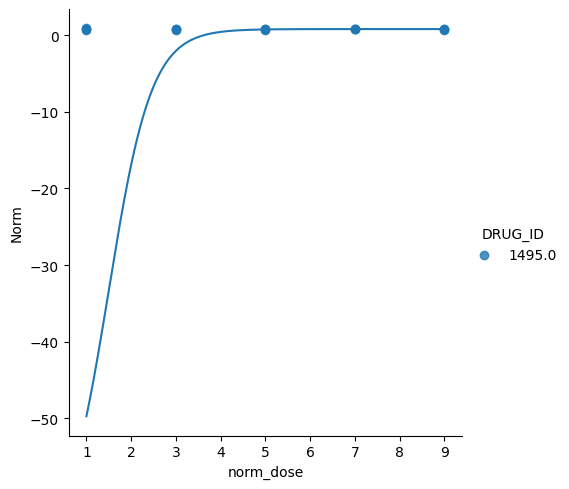

In [89]:
curve_fit(data_for_curve('714_b_17','C32',1495))

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\4151788788.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


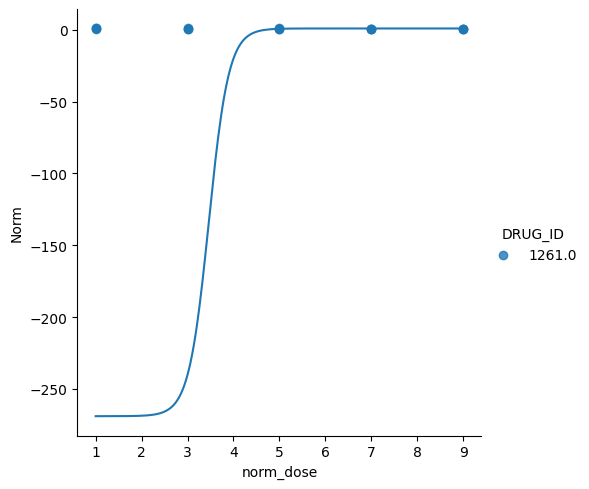

In [90]:
curve_fit(data_for_curve('714_b_17','C32',1261))

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\4151788788.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


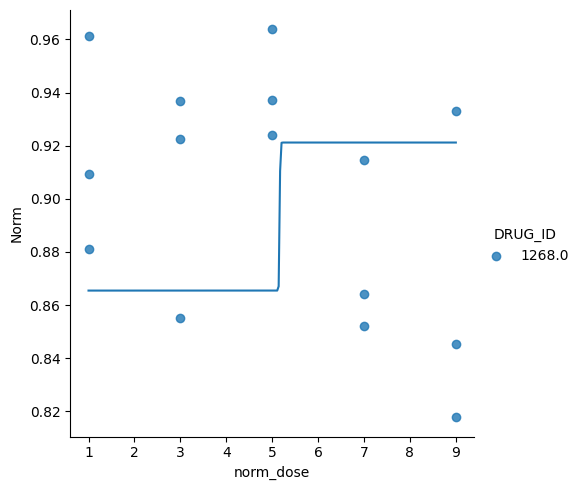

In [91]:
curve_fit(data_for_curve('714_b_17','C32',1268))

In [93]:
#curve_fit(data_for_curve('507_c_5','ES1',1072))

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\4151788788.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


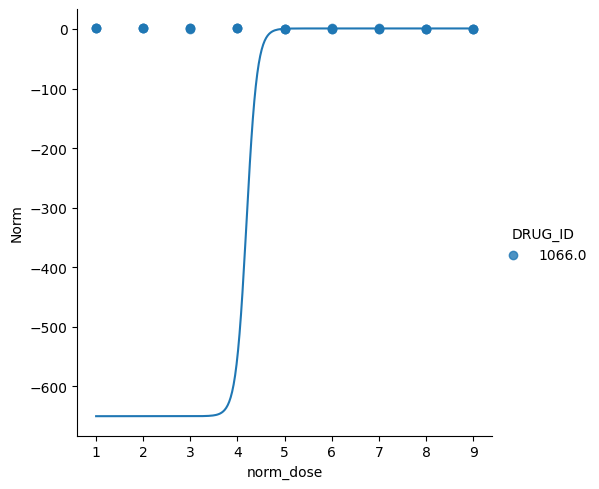

In [94]:
curve_fit(data_for_curve('507_c_5','ES1',1066))

In [95]:
curve_fit(data_for_curve('507_c_5','ES1',1069))

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_4688\4151788788.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [ ]:
data_for_curve('713_m_17','SW620',1527)

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_7136\1237771222.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_df['mean_pos'] = tidy_df['BARCODE'].map(pos_controls)
C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_7136\1237771222.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_df['mean_neg'] = tidy_df['BARCODE'].map(neg_controls)
C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_7136\1237771222.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,DRUG_ID,CONC,Norm,logDose
3861965,1527.0,4.000000,0.858701,5.39794
3861966,1527.0,1.000000,0.855133,6.00000
3861967,1527.0,0.250000,0.924162,6.60206
3861968,1527.0,0.062500,0.961447,7.20412
3861969,1527.0,0.015625,0.996833,7.80618
3864171,1527.0,4.000000,0.874163,5.39794
3864172,1527.0,1.000000,0.943846,6.00000
3864173,1527.0,0.250000,0.986030,6.60206
3864174,1527.0,0.062500,1.037233,7.20412
3864175,1527.0,0.015625,1.044690,7.80618


C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_2960\63559802.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


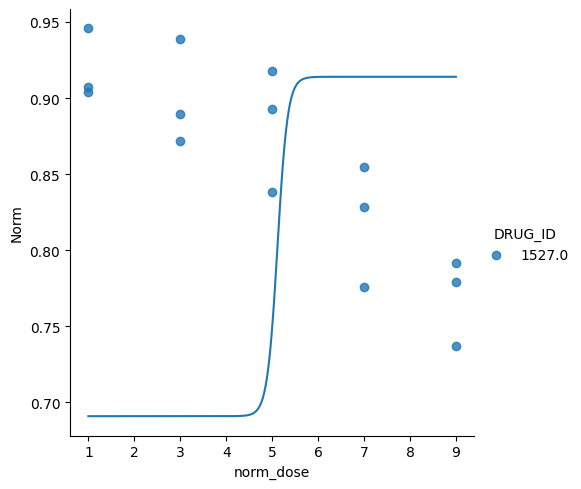

In [ ]:
curve_fit(data_for_curve('713_m_17','SW620',1527))

C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_2960\63559802.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


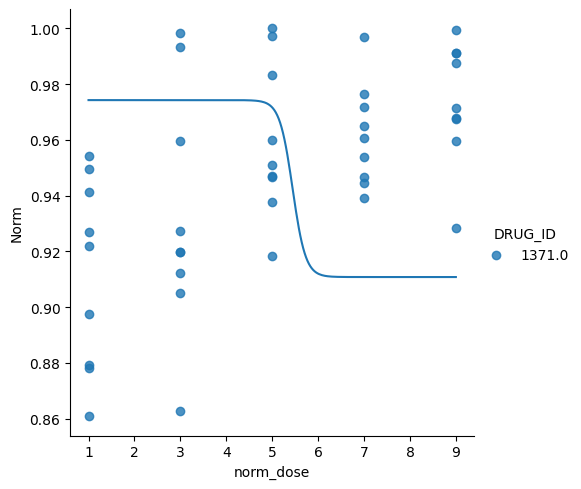

In [ ]:
curve_fit(data_for_curve('713_m_17','SW620',1371))

In [ ]:
data_for_curve('714_b_17','SK-MEL-2',1373)

,DRUG_ID,CONC,Norm,norm_dose,logDose,logCONC
2637314,1373.0,10.000000,0.373253,9.0,5.045757,5.00000
2637315,1373.0,2.500000,0.229700,7.0,5.154902,5.60206
2637316,1373.0,0.625000,0.498300,5.0,5.301030,6.20412
2637317,1373.0,0.156250,0.714474,3.0,5.522879,6.80618
2637318,1373.0,0.039062,0.760329,1.0,6.000000,7.40824
2647119,1373.0,10.000000,0.421146,9.0,5.045757,5.00000
2647120,1373.0,2.500000,0.246708,7.0,5.154902,5.60206
2647121,1373.0,0.625000,0.489806,5.0,5.301030,6.20412
2647122,1373.0,0.156250,0.802356,3.0,5.522879,6.80618
2647123,1373.0,0.039062,0.827912,1.0,6.000000,7.40824


C:\Users\dunphsi1\AppData\Local\Temp\1\ipykernel_2960\63559802.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name,group in compoundData:


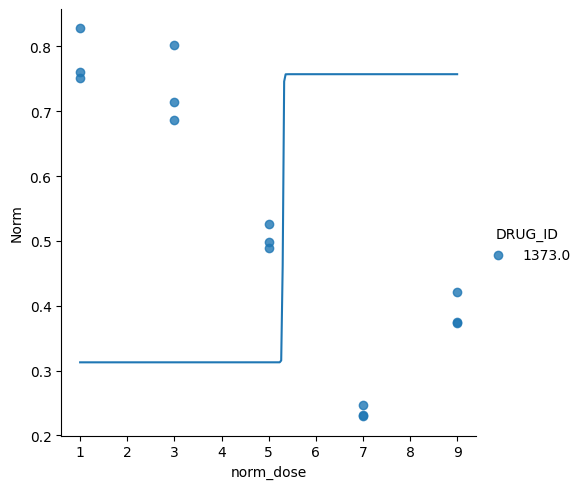

In [ ]:
curve_fit(data_for_curve('714_b_17','SK-MEL-2',1373))